In [2]:
import numpy as np
import jax.numpy as jnp
from deeprte.utils import flat_dict_to_rte_data
from deeprte.model.config import CONFIG
from deeprte.model.rte import RTEOperator
from deeprte.model.data import flat_params_to_haiku
from deeprte.model.modules import FunctionInputs

import os
os.environ["CUDA_VISIBLE"]


In [3]:
PARAMS_FILE = "/workspaces/deeprte/ckpts/train_delta_2022-11-15T17:50:42/models/latest/step_1000000_2022-11-17T05:40:43/params.npz"
# DATA_FILE = "/workspaces/deeprte/data/train/1030/test_delta_xv_it.npz"
# DATA_FILE = "/workspaces/deeprte/data/train/test_bc1_1019.npz"
# DATA_FILE = "/workspaces/deeprte/data/train/test_sin_xv.mat.npz"
# DATA_FILE = "/workspaces/deeprte/data/train/1030/test_sin.npz"
DATA_FILE = "/workspaces/deeprte/data/train/scattering-kernel/test_fixed_kernel.mat.npz"
np_params = np.load(PARAMS_FILE)
params = flat_params_to_haiku(np_params)

np_data = np.load(DATA_FILE)
rte_data = flat_dict_to_rte_data(np_data)
data, grid = rte_data["data"], rte_data["grid"]

sigma_t, sigma_a, psi_raw = data["sigma_t"], data["sigma_a"], data["psi_bc"]
sigma_raw = np.stack([sigma_a, sigma_t], axis=-1)
r, v, w_angle, rv_prime, w_prime = grid["r"], grid["v"], grid["w_angle"], grid["rv_prime"], grid["w_prime"]

In [4]:
# DATA_FILE = "/workspaces/deeprte/data/train/train_delta_0921_test.npz"
# _np_data = np.load(DATA_FILE)
# _rte_data = flat_dict_to_rte_data(_np_data)
# _data, _grid = _rte_data["data"], _rte_data["grid"]
# sigma_t, sigma_a, psi_raw = data["sigma_t"], data["sigma_a"], data["psi_bc"]
# sigma_raw = np.stack([sigma_a, sigma_t], axis=-1)

In [5]:
solution = RTEOperator(CONFIG.rte_operator, use_jit=True)

2022-09-22 15:28:09.454733: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.62GiB (rounded to 6039804416)requested by op 
2022-09-22 15:28:09.455015: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:491] *___________________________________________________________________________________________________
2022-09-22 15:28:09.455498: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2130] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 6039804344 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   276.8KiB
              constant allocation:        12B
        maybe_live_out allocation:     6.2KiB
     preallocated temp allocation:    5.62GiB
                 total allocation:    5.62GiB
Peak buffers:
	Buffer 1:
		Size: 2.81GiB
		XLA Label: fusion
		S

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 6039804344 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   276.8KiB
              constant allocation:        12B
        maybe_live_out allocation:     6.2KiB
     preallocated temp allocation:    5.62GiB
                 total allocation:    5.62GiB
Peak buffers:
	Buffer 1:
		Size: 2.81GiB
		XLA Label: fusion
		Shape: f32[5898240,128]
		==========================

	Buffer 2:
		Size: 2.81GiB
		XLA Label: fusion
		Shape: f32[5898240,128]
		==========================

	Buffer 3:
		Size: 64.0KiB
		Entry Parameter Subshape: f32[128,128]
		==========================

	Buffer 4:
		Size: 64.0KiB
		Entry Parameter Subshape: f32[128,128]
		==========================

	Buffer 5:
		Size: 64.0KiB
		Entry Parameter Subshape: f32[128,128]
		==========================

	Buffer 6:
		Size: 30.0KiB
		Entry Parameter Subshape: f32[1920,4]
		==========================

	Buffer 7:
		Size: 12.5KiB
		Entry Parameter Subshape: f32[1,1600,2]
		==========================

	Buffer 8:
		Size: 12.5KiB
		Entry Parameter Subshape: f32[1600,2]
		==========================

	Buffer 9:
		Size: 12.5KiB
		Entry Parameter Subshape: f32[1600,2]
		==========================

	Buffer 10:
		Size: 7.5KiB
		Entry Parameter Subshape: f32[1,1920]
		==========================

	Buffer 11:
		Size: 6.2KiB
		Operator: op_name="jit(<lambda>)/jit(main)/vmap(while)/body/scatter[update_consts=() dimension_numbers=ScatterDimensionNumbers(update_window_dims=(0, 1), inserted_window_dims=(), scatter_dims_to_operand_dims=(1,)) indices_are_sorted=True unique_indices=True mode=GatherScatterMode.CLIP]" source_file="/workspaces/deeprte/deeprte/model/mapping.py" source_line=239
		XLA Label: fusion
		Shape: f32[1,1600]
		==========================

	Buffer 12:
		Size: 6.0KiB
		XLA Label: fusion
		Shape: f32[1536]
		==========================

	Buffer 13:
		Size: 5.0KiB
		Entry Parameter Subshape: f32[10,128]
		==========================

	Buffer 14:
		Size: 1.5KiB
		Entry Parameter Subshape: f32[6,64]
		==========================

	Buffer 15:
		Size: 512B
		Entry Parameter Subshape: f32[128]
		==========================



In [7]:
import time
# idx = np.random.randint(20)
idx = 1

sigma = FunctionInputs(x=r.reshape(-1, 2), f=sigma_raw[idx].reshape(1, -1, 2))
psi_bc = FunctionInputs(x=rv_prime.reshape(-1, 4), f=psi_raw[idx].reshape(1, -1) * w_prime.flatten())
start = time.time()
# for i in range(10):
out, state = solution.vrho(params, None, 0, r.reshape(-1, 2), sigma, psi_bc, (v, w_angle))
# end = time.time()
# print((end-start)/10)
phi_pre = out.reshape((41,41))
phi_label = data["phi"][idx].reshape((41,41))
print(np.sqrt(np.mean((phi_label - phi_pre)**2)/np.mean(phi_label**2)), idx)

0.024664659 1


In [ ]:
# import matplotlib.pyplot as plt

# idx = np.random.randint(2000)
# r = grid["r"]
# fig = plt.figure()

# phi_label = data["phi"][idx].reshape((41,41))
# cs = plt.contour(r[..., 0],
#     r[..., 1],
#     phi_label,)
# cbar = fig.colorbar(cs)
# plt.show()
# idx+=1
# print(idx)

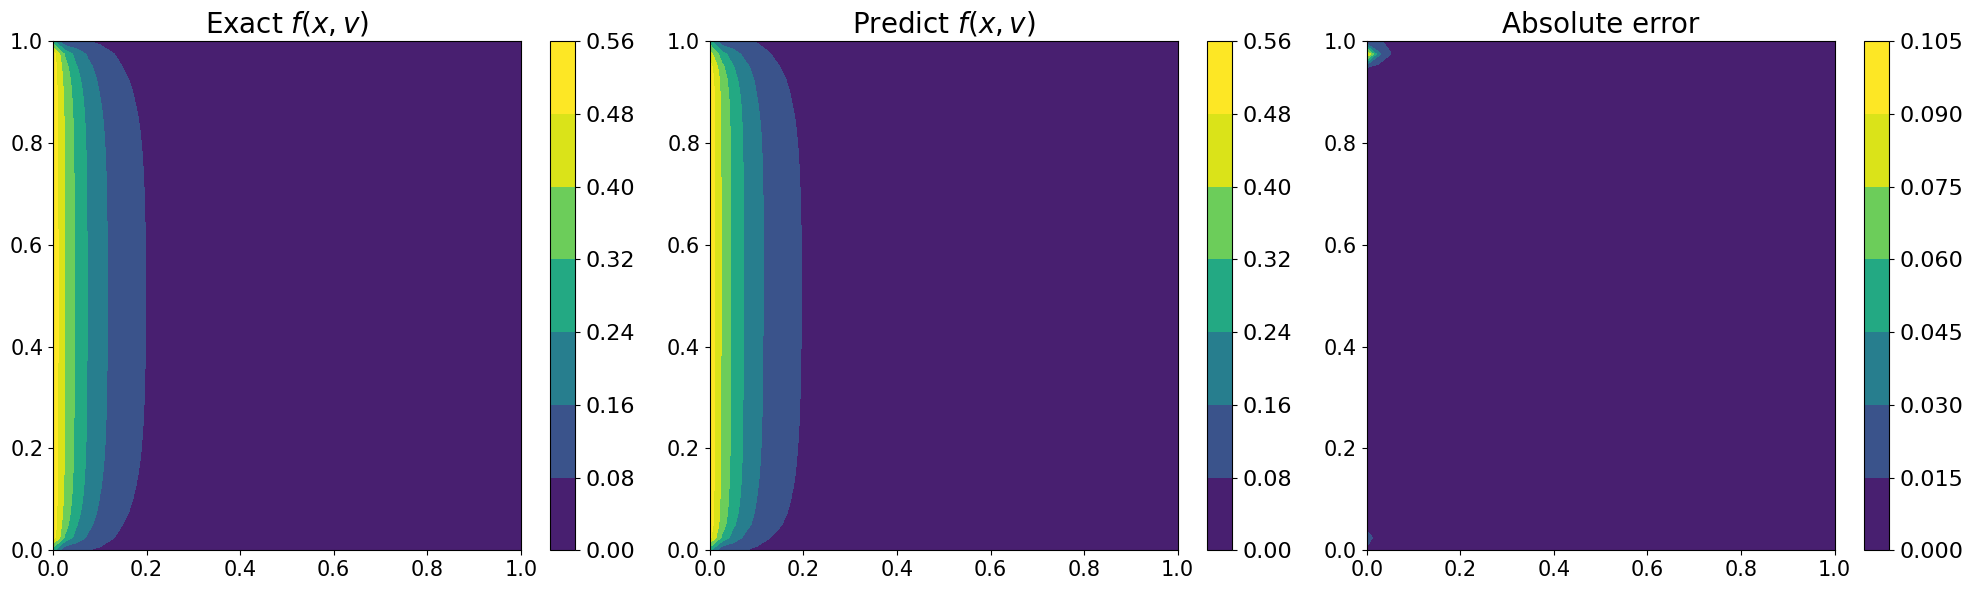

0.024664659


In [8]:
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = mpl.colormaps['viridis'](np.linspace(0, 1.2, 128))
r = grid["r"]


fig, _axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6) )
fig.subplots_adjust(hspace=0.3)
axs = _axs.flatten()

# fig = px.density_contour(phi_label)
# fig.show()

cs_1 = axs[0].contourf(
    r[..., 0],
    r[..., 1],
    phi_label,
    cmap = ListedColormap(viridis)
)
axs[0].set_title(r"Exact $f(x,v)$", fontsize=20)
axs[0].tick_params(axis='both', labelsize=15)
cbar = fig.colorbar(cs_1)
cbar.ax.tick_params(labelsize=16) 


# fig = px.density_contour(phi_pre)
cs_2 = axs[1].contourf(
    r[..., 0],
    r[..., 1],
    phi_pre,
        cmap = ListedColormap(viridis)
)
axs[1].set_title(r"Predict $f(x,v)$", fontsize=20)
axs[1].tick_params(axis='both', labelsize=15)
cbar = fig.colorbar(cs_2)
cbar.ax.tick_params(labelsize=16) 

cs_3 = axs[2].contourf(
    r[..., 0],
    r[..., 1],
    abs(phi_pre-phi_label),
    cmap = ListedColormap(viridis)
)
axs[2].set_title(r"Absolute error", fontsize=20)
axs[2].tick_params(axis='both', labelsize=15)
cbar = fig.colorbar(cs_3)
cbar.ax.tick_params(labelsize=16) 

plt.tight_layout()



plt.show()
print(np.sqrt(np.mean((phi_label - phi_pre)**2)/np.mean(phi_label**2)))

In [ ]:
fig, _axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
fig.subplots_adjust(hspace=0.3)
axs = _axs.flatten()

axs[0].plot(phi_pre[0,:])

axs[1].plot(phi_label[0,:])
plt.show()

rate = np.max(phi_label)/np.max(phi_pre)
print(rate)

In [ ]:
plt.plot(phi_pre[0,:])
plt.plot(phi_label[0,:])
plt.show()

In [ ]:
plt.plot(data["psi_bc"][0][0:40,6])

In [27]:
fig = plt.figure(figsize=(20, 8))
fig = px.density_contour(phi_label)
plt.show()

<Figure size 2000x800 with 0 Axes>

In [7]:
from cycler import cycler
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2 * np.pi, 50)
offsets = np.linspace(0, 2 * np.pi, 4, endpoint=False)
yy = np.transpose([np.sin(x + phi) for phi in offsets])

default_cycler = (cycler(color=['r', 'g', 'b', 'y']) +
                  cycler(linestyle=['-', '--', ':', '-.']))

plt.rc('lines', linewidth=4)
plt.rc('axes', prop_cycle=default_cycler)